This article goes through the implementation of Graph Convolution Networks (GCN) using [Spektral API](https://graphneural.network/getting-started/), which is a Python library for graph deep learning based on Tensorflow 2. We are going to perform Semi-Supervised Node Classification using [CORA dataset](https://linqs.soe.ucsc.edu/data), similar to the work presented in the original GCN paper by [Thomas Kipf and Max Welling (2017)](https://arxiv.org/pdf/1609.02907.pdf).

# Dataset Overview
CORA citation network dataset consists of 2708 nodes, where each node represents a document or a technical paper. The node features are bag-of-words representation that indicates the presence of a word in the document. The vocabulary — hence, also the node features — contains 1433 words.

In [24]:
!pip install spektral

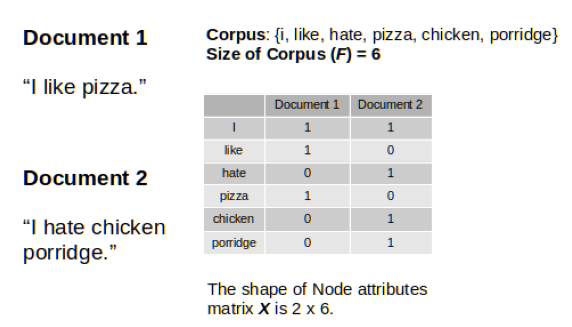

In [32]:
#importing dependencies

import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool
#from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from random import shuffle
import cv2
img = cv2.imread('CORA.png')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)

the problem is similar like Text Classification Problem
Since we are going to classify documents based on their textual features, a common machine learning way to look at this problem is by seeing it as a supervised text classification problem. Using this approach, the machine learning model will learn each document’s hidden representation only based on its own features.



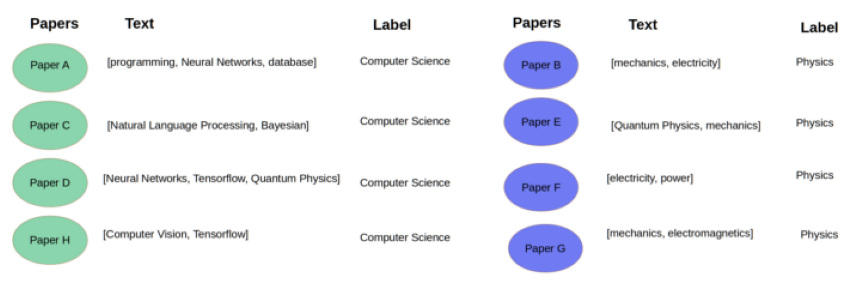

In [14]:
img = cv2.imread('text.png')
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(img)

Illustration of text classification approach on a document classification problem (image by author)
This approach might work well if there are enough labeled examples for each class. Unfortunately, in real world cases, labeling data might be expensive.
What is another approach to solve this problem?
Besides its own text content, normally, a technical paper also cites other related papers. Intuitively, the cited papers are likely to belong to similar research area.
In this citation network dataset, we want to leverage the citation information from each paper in addition to its own textual content. Hence, the dataset has now turned into a network of papers.


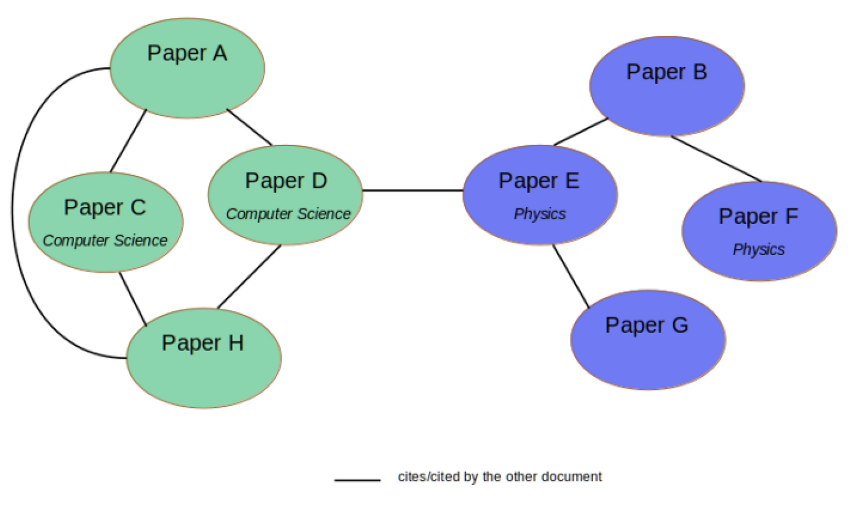

In [16]:
img = cv2.imread('doc.png')
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(img)


Illustration of citation network dataset with partly labeled data (image by author)
Using this configuration, we can utilize Graph Neural Networks, such as Graph Convolutional Networks (GCNs), to build a model that learns the documents interconnection in addition to their own textual features. The GCN model will learn the nodes (or documents) hidden representation not only based on its own features, but also its neighboring nodes’ features. Hence, we can reduce the number of necessary labeled examples and implement semi-supervised learning utilizing the Adjacency Matrix (A) or the nodes connectivity within a graph.
Another case where Graph Neural Networks might be useful is when each example does not have distinct features on its own, but the relations between the examples can enrich the feature representations.


# Implementation of Graph Convolutional Networks
## Loading and Parsing the Dataset

In [37]:
#loading the data
import sklearn
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = sklearn.utils.shuffle(all_data,random_state=random_state)

In cora.content file:<br>
The first element indicates the node name<br>
The second until the last second elements indicate the node features<br>
The last element indicates the label of that particular node<br>

In cora.cites file:<br>
Each line indicates the tuple of connected nodes

In [38]:
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Rule_Learning', 'Probabilistic_Methods', 'Theory', 'Reinforcement_Learning', 'Genetic_Algorithms', 'Case_Based', 'Neural_Networks'}

Number of classes:  7


# Setting the Train, Validation, and Test Mask
We will feed in the Node Features Matrix (X) and Adjacency Matrix (A) to the neural networks. We are also going to set Boolean masks with a length of N for each training, validation, and testing dataset. The elements of those masks are True when they belong to corresponding training, validation, or test dataset. For example, the elements of train mask are True for those which belong to training data.

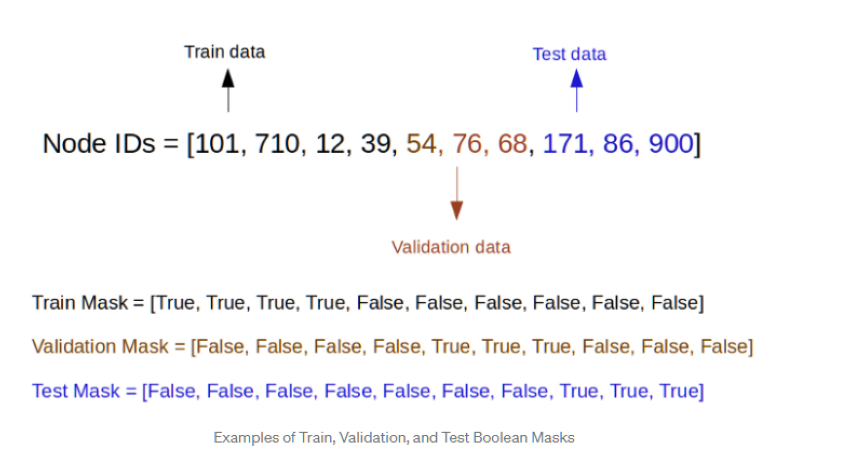

In [39]:
img = cv2.imread('train.png')
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(img)

In [40]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

train_idx,val_idx,test_idx = limit_data(labels)

#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [41]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


## Show Data Distribution

In [58]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [59]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))


Training Data Distribution: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [60]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))


Validation Data Distribution: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


# Converting the label to one-hot encoding
The last step before building our GCN is, just like any other machine learning model, encoding the labels and then converting them to one-hot encoding.

In [42]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [63]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 1433)         0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
gcn_conv_2 (GCNConv)            (None, 16)           22928       dropout_3[0][0]                  
                                                                 input_6[0][0]              

# Train the Graph Convolutional Networks
We are implementing Transductive Learning, which means we will feed the whole graph to both training and testing. We separate the training, validation, and testing data using the Boolean masks we have constructed before. These masks will be passed to sample_weight argument. We set the batch_size to be the whole graph size, otherwise the graph will be shuffled.

To better evaluate the model performance for each class, we use F1-score instead of accuracy and loss metrics.

In [64]:

# Train model
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.1163 - acc: 0.1500 - val_loss: 0.3655 - val_acc: 0.2520
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.1094 - acc: 0.2286 - val_loss: 0.3575 - val_acc: 0.2920
Epoch 3/200
1/1 [==============================] - 0s 204ms/step - loss: 0.1040 - acc: 0.2786 - val_loss: 0.3499 - val_acc: 0.3740
Epoch 4/200
1/1 [==============================] - 0s 183ms/step - loss: 0.0970 - acc: 0.4714 - val_loss: 0.3422 - val_acc: 0.4120
Epoch 5/200
1/1 [==============================] - 0s 452ms/step - loss: 0.0940 - acc: 0.3643 - val_loss: 0.3346 - val_acc: 0.4680
Epoch 6/200
1/1 [==============================] - 0s 240ms/step - loss: 0.0905 - acc: 0.5214 - val_loss: 0.3268 - val_acc: 0.5200
Epoch 7/200
1/1 [==============================] - 0s 174ms/step - loss: 0.0851 - acc: 0.5714 - val_loss: 0.3188 - val_acc: 0.5500
Epoch 8/200
1/1 [==============================] - 0s 182ms/step - loss: 0.0817 - acc: 0.

# Hidden Layers Activation Visualization using t-SNE
Let’s now use t-SNE to visualize the hidden layer representations. We use t-SNE to reduce the dimension of the hidden representations to 2-D. Each point in the plot represents each node (or document), while each color represents each class.

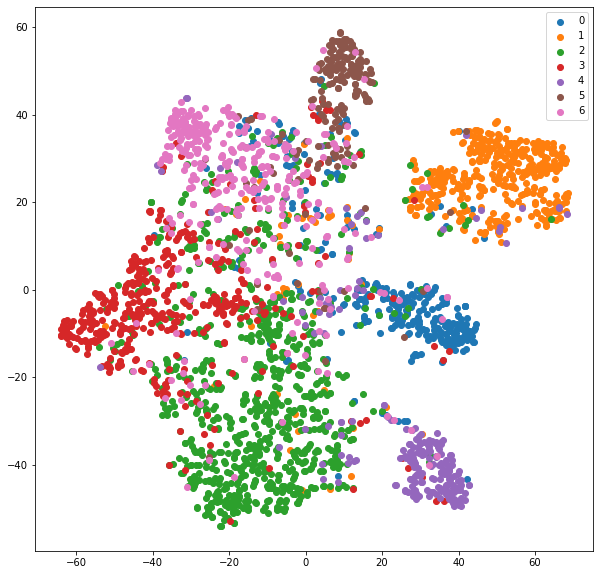

In [47]:
#Get the hidden layer representation after the first GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

# Comparison to Fully-Connected Neural Networks
## Building and Training FNN


In [66]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.2183 - acc: 0.1286 - val_loss: 0.4303 - val_acc: 0.3660
Epoch 2/200
1/1 [==============================] - 1s 810ms/step - loss: 0.1747 - acc: 0.3786 - val_loss: 0.3935 - val_acc: 0.4840
Epoch 3/200
1/1 [==============================] - 0s 152ms/step - loss: 0.1384 - acc: 0.5714 - val_loss: 0.3610 - val_acc: 0.5340
Epoch 4/200
1/1 [==============================] - 0s 198ms/step - loss: 0.1117 - acc: 0.6571 - val_loss: 0.3292 - val_acc: 0.5480
Epoch 5/200
1/1 [==============================] - 0s 168ms/step - loss: 0.0872 - acc: 0.7714 - val_loss: 0.2980 - val_acc: 0.5600
Epoch 6/200
1/1 [==============================] - 0s 148ms/step - loss: 0.0654 - acc: 0.8500 - val_loss: 0.2709 - val_acc: 0.5860
Epoch 7/200
1/1 [==============================] - 0s 155ms/step - loss: 0.0510 - acc: 0.9214 - val_loss: 0.2551 - val_acc: 0.5880
Epoch 8/200
1/1 [==============================] - 0s 146ms/step - loss: 0.0427 - acc:

In [67]:
# Evaluate model
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.52      0.54      0.53       114
    Genetic_Algorithms       0.63      0.82      0.71       156
       Neural_Networks       0.72      0.54      0.62       290
 Probabilistic_Methods       0.70      0.54      0.61       172
Reinforcement_Learning       0.49      0.62      0.55        85
         Rule_Learning       0.47      0.63      0.54        60
                Theory       0.41      0.46      0.43       123

              accuracy                           0.59      1000
             macro avg       0.56      0.59      0.57      1000
          weighted avg       0.61      0.59      0.59      1000



# Get hidden layer representation for FNN


In [68]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

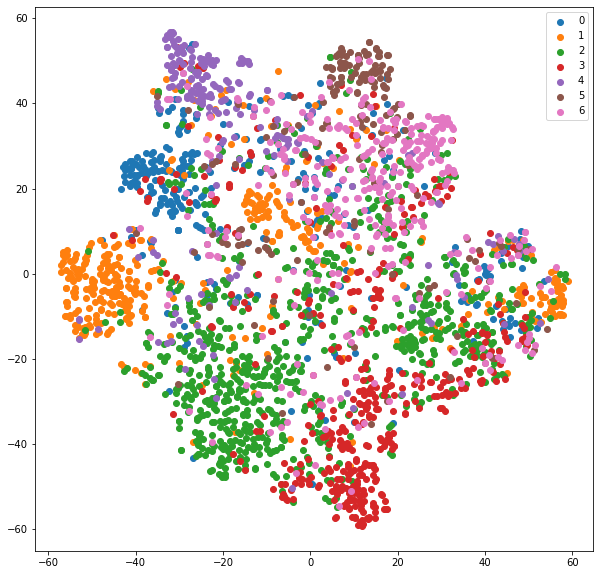

In [69]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)